In [12]:
import matplotlib.pyplot as plt
import numpy as np 
import py2neo as pn 
import random as rd
import timeit
import math
import copy

In [38]:
def barabasi(total_n, starting_n, starting_b, relation, cap=0):
    ### Generate a Barabasi-Albert network simulation
    # total_n: total number of nodes
    # starting_n: number of nodes to generate edges uniformly at random
    # returns subgraph: neo4j graph object
    ###
    edges = []
    nodes = [pn.Node('User', name='user' + str(i)) for i in range(starting_n)]
    for i in range(starting_n):
        # Generate links uniformly at random
        temp_list = list(range(starting_n))
        temp_list.remove(i)
        linkto = rd.sample(temp_list, starting_b)
        temp = [pn.Relationship(nodes[i], relation, nodes[j]) for j in linkto]
        edges.extend(temp)
    for l in range(starting_n, total_n):
        nodes.append(pn.Node('User', name='user' + str(l)))
        n = len(edges)
        # Compute the probability for a new node to connect to each existing node
        if cap == 0:
            temp_probs = [len(list(filter(lambda x: x.end_node == nodes[j] or x.start_node == nodes[j]
                                      , edges)))/(2*n) for j in range(len(nodes))]
        else:
            temp_probs = []
            for j in range(len(nodes)):
                if len(list(filter(lambda x: x.end_node == nodes[j], edges))) > cap:
                    temp_probs.append(0)
                else:
                    temp_probs.append(len(list(filter(lambda x: x.end_node == nodes[j] 
                                                      or x.start_node == nodes[j], edges))))  
            temp_probs = np.divide(temp_probs, sum(temp_probs))
        
        # Generate links for a new node
        temp = [pn.Relationship(nodes[l], relation, nodes[j]) for j in range(l) 
                        if rd.uniform(0,1) < temp_probs[j] and l != j]
        edges.extend(temp)
    subgraph = pn.Subgraph(nodes,edges)
    return subgraph

In [3]:
def postpublish(graph, m0, m1, cap = 0):
    ### Simulate a list of posts and users who create them
    # graph: py2neo object for follower network
    # m0: starting number of posts
    # m1: total number of posts
    # returns postpublished and relationship subgraph
    ###
    postpublished = []
    relationships = []
    
    # Get the users and the number of users
    nodes = list(graph.run('MATCH (n: User) RETURN n'))
    n = len(nodes)
    
    # Generate the first posts
    for i in range(m0):
        new_post = pn.Node('Post', name='post' + str(i))
        postpublished.append(new_post)
        relationships.append(pn.Relationship(rd.choice(nodes)[0],'published',new_post))
    
    # Generate the rest of the posts
    for m in range(m0,m1):
        new_post = pn.Node('Post', name='post' + str(m))
        # Compute the prob that anyone posts
        probs = []
        for k in range(n):
            # Count number of posts
            temp_probs = len(list(filter(lambda x: x.start_node == nodes[k][0], relationships)))
            if temp_probs > cap and cap != 0:
                probs.append(0)
                continue
            # Count the number of friends
            temp_probs = temp_probs + list(graph.run('MATCH (n:User {name:"user' + str(k) + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
            # Count number of followers
            temp_probs = temp_probs + list(graph.run('MATCH (n:User {name:"user' + str(k) + '"})<-[:follow]-(a) return count(a)').data()[0].values())[0]
            probs.append(temp_probs)
        # Choose a user for new post
        temp_user = rd.choices(nodes, weights = probs)
        postpublished.append(temp_user[0], 'published', new_post)  
    subgraph = pn.Subgraph(postpublished,relationships)
    return subgraph

In [4]:
def postview(P,N,graph):
    # depends on friends/followers/reads
    user_list = [pn.Node('User', name='user' + str(i)) for i in N]
    post_list = [pn.Node('Post', name='post' + str(i)) for i in P]
    view_list = [0] * len(P)
    rel_list = []
    k_all_friends = 0
    k_all_follow = 0
    for i in P:
        user = list(graph.run('match (n:Post{name:"post' + str(i) + '"})<-[:published]-(a) return a').data()[0].values())[0].nodes[0]['name']
        friends = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
        k_all_friends += friends
        follow = list(graph.run('MATCH (n:User {name:"' + user + '"})<-[:follow]-(a) return count(a)').data()[0].values())[0]
        k_all_follow += follow
    for i in P:
        user = list(graph.run('match (n:Post{name:"post' + str(i) + '"})<-[:published]-(a) return a').data()[0].values())[0].nodes[0]['name']
        user_list_m = copy.deepcopy(user_list)
        for n in user_list_m:
            if n['name'] == user:
                user_list_m.remove(n)
        friends = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
        follow = list(graph.run('MATCH (n:User {name:"' + user + '"})<-[:follow]-(a) return count(a)').data()[0].values())[0]
        p = (friends + follow + view_list[i]) / (k_all_friends + k_all_follow + sum(view_list))
        p_random = rd.random()
        if p_random <= p:
            user_choice = np.random.choice(user_list_m,1)[0]
            rel_list.append(pn.Relationship(user_choice,'viewed',post_list[i]))
            view_list[i] += 1
    s = pn.Subgraph(post_list,rel_list)
    return s

In [5]:
def postlike(P,N,graph):
    user_list = [pn.Node('User', name='user' + str(i)) for i in N]
    post_list = [pn.Node('Post', name='post' + str(i)) for i in P]
    liked_list = [0] * len(P)
    rel_list = []
    k_all_friends = 0
    k_all_follow = 0
    k_all_posted = 0
    for i in P:
        user = list(graph.run('match (n:Post{name:"post' + str(i) + '"})<-[:published]-(a) return a').data()[0].values())[0].nodes[0]['name']
        friends = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
        k_all_friends += friends
        follow = list(graph.run('MATCH (n:User {name:"' + user + '"})<-[:follow]-(a) return count(a)').data()[0].values())[0]
        k_all_follow += follow
        post = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:published]->(a) return count(a)').data()[0].values())[0] 
        k_all_posted += post
    for i in P:
        user = list(graph.run('match (n:Post{name:"post' + str(i) + '"})<-[:published]-(a) return a').data()[0].values())[0].nodes[0]['name']
        user_list_m = copy.deepcopy(user_list)
        for n in user_list_m:
            if n['name'] == user:
                user_list_m.remove(n)
        friends = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
        follow = list(graph.run('MATCH (n:User {name:"' + user + '"})<-[:follow]-(a) return count(a)').data()[0].values())[0]
        post = list(graph.run('MATCH (n:User {name:"' + user + '"})-[:published]->(a) return count(a)').data()[0].values())[0]
        for j in N:
            p = (friends + follow + post + liked_list[i]) / (k_all_friends + k_all_follow + k_all_posted + sum(liked_list))
            p_random = rd.random()
            if p_random <= p:
                user_choice = np.random.choice(user_list_m,1)[0]
                rel_list.append(pn.Relationship(user_choice,'liked',post_list[i]))
                liked_list[i] += 1
    s = pn.Subgraph(post_list,rel_list)
    return s

In [42]:
# start a new project in Neo4j and set connections
graph = pn.Graph(
    host = 'localhost',
    http_port = '7474',
    user = 'neo4j',
    password = '2500'
    )   
# Hyperparameters
NUsers = 500
NPosts = 5000
P=list(range(NPosts))
N=list(range(NUsers))

In [ ]:
################ Experiment 1 - no cap
start = timeit.default_timer()
graph.run('match (n:User) detach delete n')
graph.run('match (n:Post) detach delete n')
# Create and Merge Friends subgraph
subgraph_friends = barabasi(NUsers,10,5, 'friends')
graph.merge(subgraph_friends,'User','name')
print("Step1 done")
stop = timeit.default_timer()
print('Time: ', stop - start)  
# Create and Merge Follower subgraph
subgraph_follow = barabasi(NUsers,10,5, 'follows')
graph.merge(subgraph_follow,'User','name')
print("Step2 done")
stop = timeit.default_timer()
print('Time: ', stop - start)  
# Create and Merge Post Published subgraph
subgraph_post = postpublish(graph,NPosts,10)
graph.merge(subgraph_post, 'User', 'name')
print("Step3 done")
stop = timeit.default_timer()
print('Time: ', stop - start)  
# Create and Merge Post Viewing subgraph
s_posts_viewed = postview(P,N,graph)
graph.merge(s_posts_viewed,'User','name')
print("Step4 done")
stop = timeit.default_timer()
print('Time: ', stop - start)  
# Create and Merge Post Liking subgraph
s_posts_liked = postlike(P,N,graph)
graph.merge(s_posts_liked,'User','name')
print("Step5 done")
stop = timeit.default_timer()
print('Time: ', stop - start)  


stop = timeit.default_timer()
print('Time: ', stop - start)  

In [ ]:
# Store values for post liked and post viewed
followers = {}
friends = {}
posts = {}
exp1_posts_viewed = {}
exp1_posts_liked = {}
for i in N:
    followers['user'+str(i)] = list(graph.run('MATCH (n:User {name:"user' + str(i) + '"})<-[:follows]-(a) return count(a)').data()[0].values())[0]
    friends['user'+str(i)] = list(graph.run('MATCH (n:User {name:"user' + str(i) + '"})-[:friends]-(a) return count(a)').data()[0].values())[0]
    posts['user'+str(i)] = list(graph.run('MATCH (n:User {name:"user' + str(i) + '"})-[:published]->(a) return count(a)').data()[0].values())[0]
for i in P:
    exp1_posts_viewed['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:viewed]-(a) return count(a)').data()[0].values())[0]
    exp1_posts_liked['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:liked]-(a) return count(a)').data()[0].values())[0]
    
# Order the dictionaries
friends_exp1 = {k: v for k, v in sorted(friends.items(),
                                   key=lambda item: item[1], reverse=True)}
followers_exp1 = {k: v for k, v in sorted(followers.items(),
                                   key=lambda item: item[1], reverse=True)}
posts_exp1 = {k: v for k, v in sorted(posts.items(),
                                   key=lambda item: item[1], reverse=True)}


In [33]:
list(graph.run('MATCH (n:User {name:"user' + str(8) + '"})<-[:follows]-(a) return count(a)').data()[0].values())[0]

5

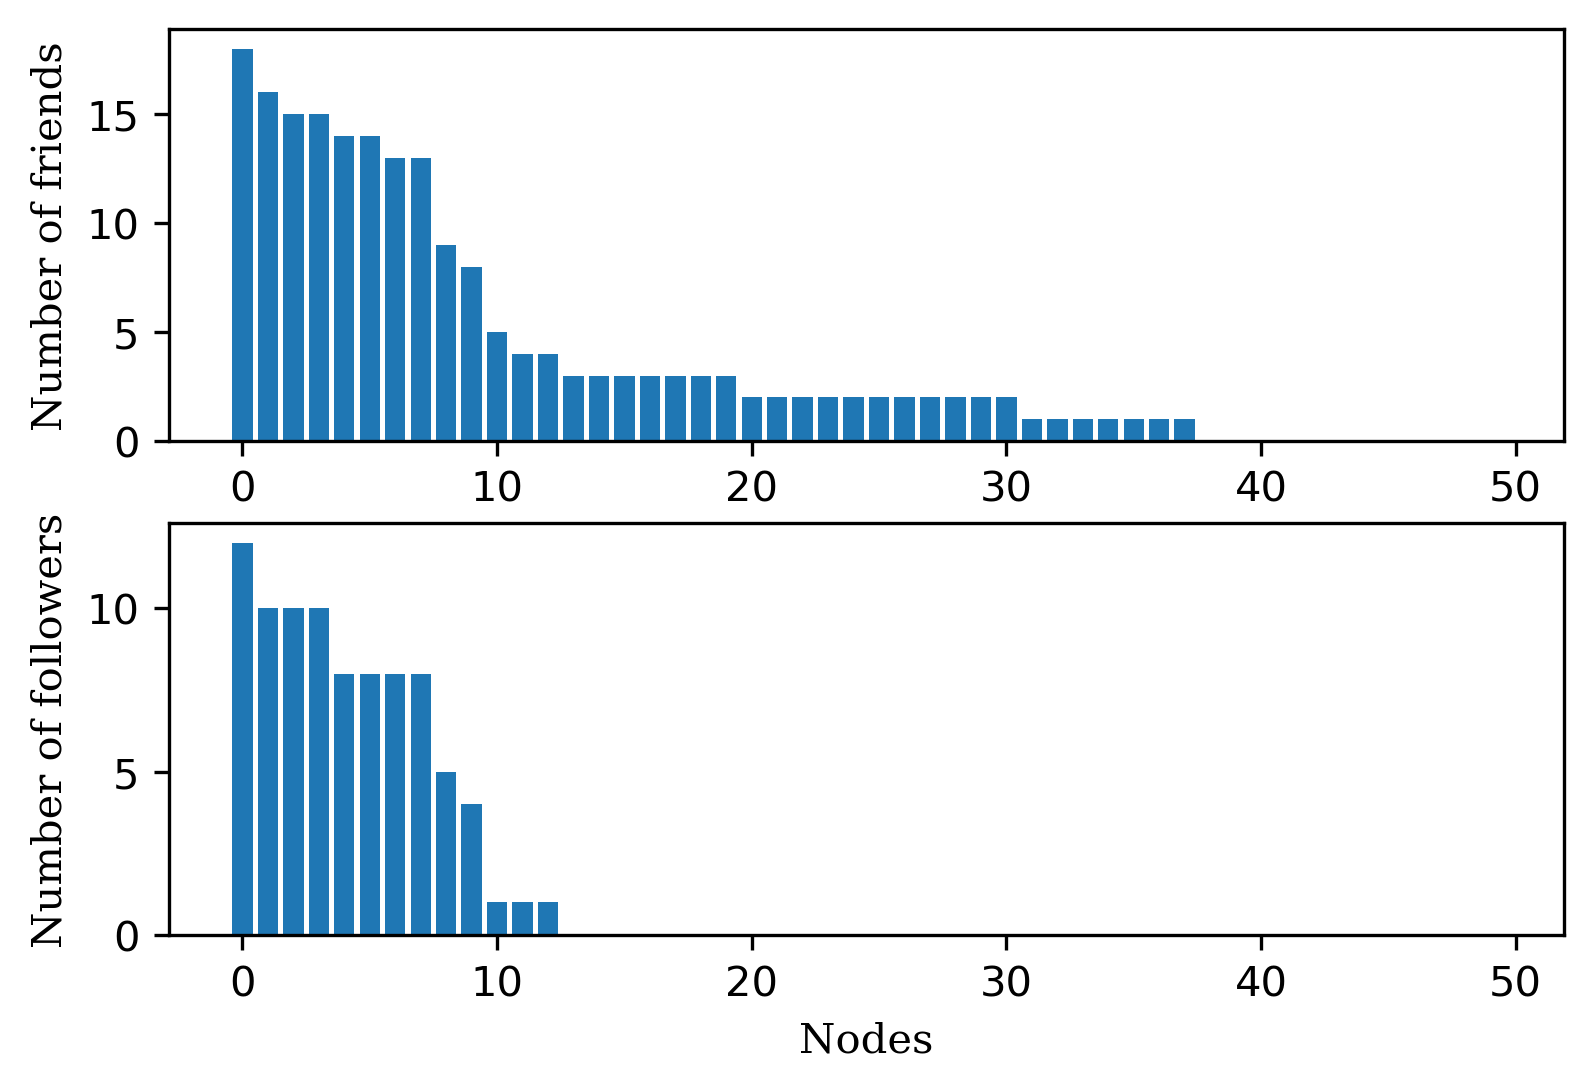

In [41]:
# Plot the 300 most used words of the dictionary
plot_length = 50
plt.figure(dpi=300)
plt.subplot(2,1,1)
plt.bar(range(plot_length), list(friends_exp1.values())[0:plot_length], align='center')
plt.ylabel("Number of friends", family="serif")
plt.subplot(2,1,2)
plt.bar(range(plot_length), list(followers_exp1.values())[0:plot_length], align='center')
plt.xlabel("Nodes", family="serif")
plt.ylabel("Number of followers", family="serif")
plt.savefig('friends.png')



In [23]:
friends

{'user0': 0,
 'user1': 0,
 'user2': 0,
 'user3': 0,
 'user4': 0,
 'user5': 0,
 'user6': 0,
 'user7': 0,
 'user8': 0,
 'user9': 0,
 'user10': 0,
 'user11': 0,
 'user12': 0,
 'user13': 0,
 'user14': 0,
 'user15': 0,
 'user16': 0,
 'user17': 0,
 'user18': 0,
 'user19': 0,
 'user20': 0,
 'user21': 0,
 'user22': 0,
 'user23': 0,
 'user24': 0,
 'user25': 0,
 'user26': 0,
 'user27': 0,
 'user28': 0,
 'user29': 0,
 'user30': 0,
 'user31': 0,
 'user32': 0,
 'user33': 0,
 'user34': 0,
 'user35': 0,
 'user36': 0,
 'user37': 0,
 'user38': 0,
 'user39': 0,
 'user40': 0,
 'user41': 0,
 'user42': 0,
 'user43': 0,
 'user44': 0,
 'user45': 0,
 'user46': 0,
 'user47': 0,
 'user48': 0,
 'user49': 0}

In [ ]:
################ Experiment 2 - cap on friends
##### With this cap a new node cannot become friends 
##### of a node with too many friends 
start = timeit.default_timer()
cap = 0
graph.run('match (n:User) detach delete n')
graph.run('match (n:Post) detach delete n')
# Create and Merge Friends subgraph
subgraph_friends = barabasi(NUsers,10,5, 'friends', cap)
graph.merge(subgraph_friends,'User','name')
# Create and Merge Follower subgraph
subgraph_follow = barabasi(NUsers,10,5, 'follow')
graph.merge(subgraph_follow,'User','name')
# Create and Merge Post Published subgraph
subgraph_post = postpublish(graph,NPosts,10)
graph.merge(subgraph_post, 'User', 'name')
# Create and Merge Post Viewing subgraph
s_posts_viewed = postview(P,N,graph)
graph.merge(s_posts_viewed,'User','name')
# Create and Merge Post Liking subgraph
s_posts_liked = postlike(P,N,graph)
graph.merge(s_posts_liked,'User','name')


stop = timeit.default_timer()

print('Time: ', stop - start)  

In [ ]:
################ Experiment 2 - cap on friends
# Store values for post liked and post viewed
exp2_posts_viewed = {}
exp2_posts_liked = {}
for i in P:
    exp2_posts_viewed['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:viewed]-(a) return count(a)').data()[0].values())[0]
    exp2_posts_liked['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:liked]-(a) return count(a)').data()[0].values())[0]

In [ ]:
################ Experiment 3 - cap on followers
##### With this cap a new node cannot follow 
##### a node with too many followers 
start = timeit.default_timer()
cap = 0
graph.run('match (n:User) detach delete n')
graph.run('match (n:Post) detach delete n')
# Create and Merge Friends subgraph
subgraph_friends = barabasi(NUsers,10,5, 'friends')
graph.merge(subgraph_friends,'User','name')
# Create and Merge Follower subgraph
subgraph_follow = barabasi(NUsers,10,5, 'follow', cap)
graph.merge(subgraph_follow,'User','name')
# Create and Merge Post Published subgraph
subgraph_post = postpublish(graph,NPosts,10)
graph.merge(subgraph_post, 'User', 'name')
# Create and Merge Post Viewing subgraph
s_posts_viewed = postview(P,N,graph)
graph.merge(s_posts_viewed,'User','name')
# Create and Merge Post Liking subgraph
s_posts_liked = postlike(P,N,graph)
graph.merge(s_posts_liked,'User','name')


stop = timeit.default_timer()

print('Time: ', stop - start)  

In [ ]:
################ Experiment 3 - cap on followers
# Store values for post liked and post viewed
exp3_posts_viewed = {}
exp3_posts_liked = {}
for i in P:
    exp3_posts_viewed['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:viewed]-(a) return count(a)').data()[0].values())[0]
    exp3_posts_liked['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:liked]-(a) return count(a)').data()[0].values())[0]

In [ ]:
################ Experiment 4 - cap on posts
##### With this cap a node cannot post more than a certain 
##### amount of posts, new posts in the algorithm will be posted by someone else
start = timeit.default_timer()
cap = 0
graph.run('match (n:User) detach delete n')
graph.run('match (n:Post) detach delete n')
# Create and Merge Friends subgraph
subgraph_friends = barabasi(NUsers,10,5, 'friends')
graph.merge(subgraph_friends,'User','name')
# Create and Merge Follower subgraph
subgraph_follow = barabasi(NUsers,10,5, 'follow')
graph.merge(subgraph_follow,'User','name')
# Create and Merge Post Published subgraph
subgraph_post = postpublish(graph,NPosts,10, cap)
graph.merge(subgraph_post, 'User', 'name')
# Create and Merge Post Viewing subgraph
s_posts_viewed = postview(P,N,graph)
graph.merge(s_posts_viewed,'User','name')
# Create and Merge Post Liking subgraph
s_posts_liked = postlike(P,N,graph)
graph.merge(s_posts_liked,'User','name')


stop = timeit.default_timer()

print('Time: ', stop - start)  

In [ ]:
################ Experiment 4 - cap on posts
# Store values for post liked and post viewed
exp4_posts_viewed = {}
exp4_posts_liked = {}
for i in P:
    exp4_posts_viewed['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:viewed]-(a) return count(a)').data()[0].values())[0]
    exp4_posts_liked['post'+str(i)]=list(graph.run('MATCH (n:Post {name:"post' + str(i) + '"})<-[:liked]-(a) return count(a)').data()[0].values())[0]